# Cleaning - missing and duplicate data

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
# plt.style.use('ggplot')
import pandas as pd
import numpy as np

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Set max rows and columns displayed in jupyter
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", 100)

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## Generate some data - specifically a t-shirt order, use the names module to generate random names associated with each order
Order with 300 tshirts, 100 small, 100 medium and 100 large with a bunch missing of missing sizes<br>
have a name, a t-shirt size, and a weight(in pounds)<br>
Use the <a href="https://pypi.org/project/names/https://pypi.org/project/names/">names </a> module to generate random names

In [25]:
#to generate people names
# !pip install names
import names

In [26]:
# average small person weighs 100lbs
# average medium weighs 140 lbs
# average large weighs 180 lbs

#generate a bunch of t-shirts with the following mean,std,numbershirts
x = np.random.normal(100, 15, 100)
x = np.concatenate((x, np.random.normal(140, 20, 100)))
x = np.concatenate((x, np.random.normal(180, 30, 100)))

size=np.empty(300, dtype=object)
size[:99] = 'small'
size[99:199] = 'med'
size[199:300] = 'large'

d = {'weight': x, 't_shirt_size': size}
df = pd.DataFrame(data=d)
df['name'] = "Unknown"

df.name = df.name.map(lambda x: names.get_full_name())
df

,weight,t_shirt_size,name
0,104.820189,small,Deborah Bradshaw
1,78.662745,small,Betty Shannon
2,76.240932,small,Mai Audet
3,112.118586,small,Mindy Hedrick
4,91.335201,small,James Norris
...,...,...,...
295,196.398460,large,Donald Boykin
296,166.900950,large,Geneva Burgess
297,185.500967,large,Michael Needham
298,164.726392,large,Jeffrey Puckett


### Make some duplicates

In [27]:
# make some duplicates just to show how to handle duplicates (delete them)
#lets find the oldest male and female
def fun1(df,numb=5):
    #generates numb rows from df
    return (df.iloc[0:numb,:])


#generates numb rows from each group to be used as duplicates
df_dups=df.groupby('t_shirt_size').apply(fun1, numb=5)
df_dups

weight t_shirt_size               name
t_shirt_size                                                
large        199  138.423257        large      Shemeka Tweed
             200  170.820697        large      Vicky Schaich
             201  179.943743        large       Curtis Perry
             202  192.245354        large    Jean Vanblarcom
             203  187.671504        large      John Martinez
med          99   110.433988          med      Marion Murphy
             100  172.863897          med     Ronald Edwards
             101  169.014382          med       Gail Stewart
             102  123.023839          med  Chanda Trebilcock
             103  143.853752          med  Kathleen Ringrose
small        0    104.820189        small   Deborah Bradshaw
             1     78.662745        small      Betty Shannon
             2     76.240932        small          Mai Audet
             3    112.118586        small      Mindy Hedrick
             4     91.335201        small       James Norris

### Append to original dataframe

In [28]:
df=df.append(df_dups, ignore_index=True)
len(df)

315

### randomly select 20% of rows for t_shirt_size ommision

In [29]:
#first save orig size for later comparison
df['t_shirt_size_orig'] = df['t_shirt_size']

In [30]:
import random
res = random.sample(range(0, len(df)), int(0.2 * len(df)))
print(f'Number of rows to have "t_shirt_size" set to np.Nan is {len(res)}' )
for loc in res:
    df.loc[loc,'t_shirt_size'] = np.NaN

Number of rows to have "t_shirt_size" set to np.Nan is 63


In [31]:
#how many are null?
df.t_shirt_size.isna().sum()

63

### Lets take a look at the distribution


#### kind ='hist', hist will bin the number of weights and display them, hue will determine which color group they belong to

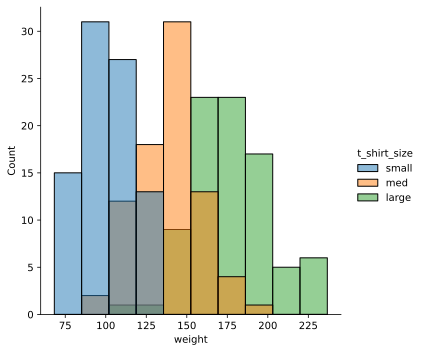

In [32]:
sns.displot(data=df, x="weight",  hue="t_shirt_size", kind='hist', fill=True);

#### kind ='kde', kde is a kernel density estimater, essentially calculates a gaussian distribution around all the points, and adds these distributions to get the smooth curves you see.  I'm showing it because its easier to see the distributions

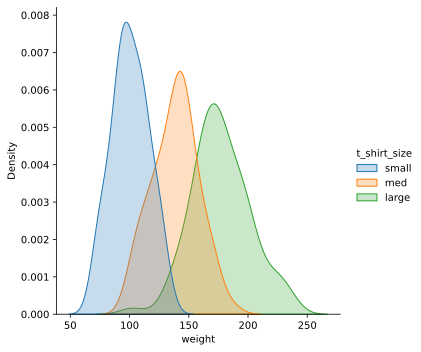

In [33]:
sns.displot(data=df, x="weight",  hue="t_shirt_size", kind='kde', fill=True);

## What to do about duplicates?  Delete them!

### Find them first

In [34]:
df.duplicated().sum()

10

### Visually Verify 

In [35]:
df[df.duplicated()].sort_values(by='name')

,weight,t_shirt_size,name,t_shirt_size_orig
311,78.662745,small,Betty Shannon,small
302,179.943743,large,Curtis Perry,large
314,91.335201,small,James Norris,small
303,192.245354,large,Jean Vanblarcom,large
309,143.853752,med,Kathleen Ringrose,med
312,76.240932,small,Mai Audet,small
305,110.433988,med,Marion Murphy,med
313,112.118586,small,Mindy Hedrick,small
306,172.863897,med,Ronald Edwards,med
300,138.423257,large,Shemeka Tweed,large


### Looks good lets dump them

In [36]:
df.drop_duplicates(inplace=True)

## What if one of the duplicated rows is missing the t-shirt size?  Then duplicated() will not find it.  Maybe we should check for duplicates in the 'name' column instead

In [37]:
df.name.duplicated().sum()

6

### Verify that they are duplicates first

In [38]:
df[df.name.duplicated()].sort_values(by='name')

,weight,t_shirt_size,name,t_shirt_size_orig
308,123.023839,med,Chanda Trebilcock,med
310,104.820189,NaN,Deborah Bradshaw,small
307,169.014382,med,Gail Stewart,med
249,180.647922,large,John Martinez,large
304,187.671504,large,John Martinez,large
301,170.820697,large,Vicky Schaich,large


### We want to delete the one that has a np.nan for t_shirt_size.

In [39]:
#code to get the condition right
# ((df.name.duplicated()) & (df.t_shirt_size.isna())).sum()
# df.t_shirt_size.isna().sum()
# (df.name.duplicated()) & (df.t_shirt_size.isna())
# df[df.name.duplicated() & (df.t_shirt_size.isna())].index

In [40]:
df.drop( df[df.name.duplicated() & (df.t_shirt_size.isna())].index, inplace=True)

## Duplicates are gone, now how to impute the missing fields

### One way is to use SimpleImputer and assign the median value to all the missing values


In [49]:
df_med=df.copy()

In [50]:
from sklearn.impute import SimpleImputer

imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  #works with strings

imp = imp.fit(df_med[['t_shirt_size']])   #here is where it determines what the most frequent is

df_med['impute_t_shirt_size']=imp.transform(df_med[['t_shirt_size']])  #here is where the transform is applied to create a new column 

In [71]:
# how many match
def printstats(df):
    tmp = df[(df['t_shirt_size'].isna())]
    numb=len(tmp)
    numbmatches=(tmp['t_shirt_size_orig']==tmp['impute_t_shirt_size']).sum()
    print(f'Correctly imputed {numbmatches} out of {numb} missing values')
printstats(df_med)

Correctly imputed 21 out of 62 missing values


In [55]:
# df_med[df_med['t_shirt_size'].isna()]

### Another way is to find the mean weight for each t-shirt size, and then assign missing value t-shirt size based on weight<br>
For each NaN assign t-shirt size to closest median

#### First calculate average weight for each t-shirt size

In [63]:
df_better=df.copy()

In [79]:
avgs = df_better.groupby('t_shirt_size').mean()
avgs.weight

t_shirt_size
large    177.410759
med      138.508626
small    101.173410
Name: weight, dtype: float64

In [66]:
#how many in each group
df_better.groupby('t_shirt_size').count()

,weight,name,t_shirt_size_orig
t_shirt_size,,,
large,82,82,82
med,78,78,78
small,82,82,82


In [80]:
#map works on a column apply works on a row, which means we have access tothe entire row

def func(row):
    if row.t_shirt_size is np.NaN:
        #get a list of differences between this weight and average weights
        lst_vals = [abs(row.weight-val) for val in avgs.weight]

        #get the index of the minimum value
        min_val = min(lst_vals)
        min_index=lst_vals.index(min_val)

        #return t_shirt_size corresponding to this index
        return avgs.index[min_index]
    #its not missing, return what's there
    return row.t_shirt_size
df_better['impute_t_shirt_size'] = df.apply(func, axis=1)

In [72]:
printstats(df_better)

Correctly imputed 49 out of 62 missing values


In [73]:
# df_better[df_better['t_shirt_size'].isna()]

# Slide for the lecture

In [78]:
def func(df, numb=5):
    return (df.iloc[0:numb,:])
    
df.groupby('t_shirt_size', dropna=False).apply(func,numb=3)

weight t_shirt_size               name t_shirt_size_orig
t_shirt_size                                                                  
large        199  138.423257        large      Shemeka Tweed             large
             201  179.943743        large       Curtis Perry             large
             202  192.245354        large    Jean Vanblarcom             large
med          99   110.433988          med      Marion Murphy               med
             100  172.863897          med     Ronald Edwards               med
             103  143.853752          med  Kathleen Ringrose               med
small        0    104.820189        small   Deborah Bradshaw             small
             1     78.662745        small      Betty Shannon             small
             2     76.240932        small          Mai Audet             small
NaN          5    112.973731          NaN       Pearl Miller             small
             19    92.639737          NaN      Yvonne Arroyo             small
             25    98.201594          NaN         James Dana             small

In [76]:
df.t_shirt_size.isna().sum()

62